# Popular Data Science Questions

[Data Science Stack Exchange](https://datascience.stackexchange.com/) (DSSE) is a question and answer site for Data Science professionals, Machine Learning specialists, and those interested in learning more about the field. Each post (each question/answer) is subjected to upvotes and downvotes - This ensures good posts stay on top and are easily identified.

In this project, we'll explore DSSE's database to find the most popular Data Science questions.

## Stack Exchange Data Explorer

Stack Exchange Data Explorer is an open source tool for running arbitrary queries against public data from the Stack Exchange network. We'll use it to explore and get the data needed for our analysis.

From the [DSSE database](https://data.stackexchange.com/datascience/query/new), let's focus our attention on the **Posts** table. We'll choose some of its columns which contain relevant information:
- *Id*: An identification number for the post
- *PostTypeId*: An identification number of the type of post
- *CreationDate*: The date and time of creation of the post
- *Score*: The post's score
- *ViewCount*: How many times the post was viewed
- *Tags*: What tags were used
- *AnswerCount*: How many answers the question got (only applicable to question posts)
- *FavoriteCount*: How many times the question was favored (only applicable to question posts)

We will also limit our analysis to questions (*PostTypeId* is 1) and recent posts only (from 2019).

Let's run a query against the DSSE database to extracts the data we need:

    SELECT Id, PostTypeId, CreationDate, Score, 
           ViewCount, Tags, AnswerCount, FavoriteCount
      FROM Posts
     WHERE PostTypeId = 1 AND YEAR(CreationDate) >= 2019;

## Data Cleaning

In [1]:
# Read the extracted data into a dataframe
import pandas as pd
questions = pd.read_csv('QueryResults.csv', parse_dates=['CreationDate'])
questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,72398,1,2020-04-15 22:28:18,0,7,<aws>,0,NaN
1,72399,1,2020-04-15 23:22:59,2,15,<deep-learning><keras><cnn>,1,NaN
2,72401,1,2020-04-15 23:39:00,0,47,<python><matplotlib><seaborn>,0,NaN
3,72402,1,2020-04-15 23:57:23,0,64,<python><pandas><numpy>,0,NaN
4,72404,1,2020-04-16 01:17:31,0,6,<autoencoder>,0,NaN


In [2]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13626 entries, 0 to 13625
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             13626 non-null  int64         
 1   PostTypeId     13626 non-null  int64         
 2   CreationDate   13626 non-null  datetime64[ns]
 3   Score          13626 non-null  int64         
 4   ViewCount      13626 non-null  int64         
 5   Tags           13626 non-null  object        
 6   AnswerCount    13626 non-null  int64         
 7   FavoriteCount  2192 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 851.8+ KB


Most of the values in *FavoriteCount* are nulls - Let's replace them with 0. For the values in *Tags* column, we'll transfrom them into lists.

In [3]:
# Fill missing values with zeros
questions.fillna(0, inplace=True)
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

# Transform strings in Tags
questions['Tags'] = questions['Tags'].str.strip('<>').str.split('><')

questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,72398,1,2020-04-15 22:28:18,0,7,[aws],0,0
1,72399,1,2020-04-15 23:22:59,2,15,"[deep-learning, keras, cnn]",1,0
2,72401,1,2020-04-15 23:39:00,0,47,"[python, matplotlib, seaborn]",0,0
3,72402,1,2020-04-15 23:57:23,0,64,"[python, pandas, numpy]",0,0
4,72404,1,2020-04-16 01:17:31,0,6,[autoencoder],0,0


## Most Used and Most Viewed

We now focus on determining the most popular tags by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [4]:
# Create a dictionary with the number of uses and views for each tag
tags = {}
for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tags:
            tags[tag][0] += 1
            tags[tag][1] += row['ViewCount']
        else:
            tags[tag] = [1, row['ViewCount']]       

In [5]:
# Create a dataframe for tag info
tag_count = pd.DataFrame(tags).transpose()
tag_count.columns=['Used', 'Viewed']
tag_count.head()

,Used,Viewed
aws,21,3487
deep-learning,1828,574431
keras,1365,688666
cnn,707,195290
python,2768,1516471


In [6]:
# Top 10 used tags
most_used = tag_count.sort_values('Used', ascending=False)[['Used']][:10]
most_used

,Used
machine-learning,4050
python,2768
deep-learning,1828
neural-network,1591
keras,1365
classification,1090
tensorflow,950
scikit-learn,870
nlp,836
cnn,707


In [7]:
# Top 10 viewed tags
most_viewed = tag_count.sort_values('Viewed', ascending=False)[['Viewed']][:10]
most_viewed

,Viewed
python,1516471
machine-learning,1022441
keras,688666
pandas,670514
deep-learning,574431
neural-network,480541
scikit-learn,363262
tensorflow,348763
classification,275407
dataframe,255882


Let's visualize the lists side-by-side:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A74BDACC8>],
      dtype=object)

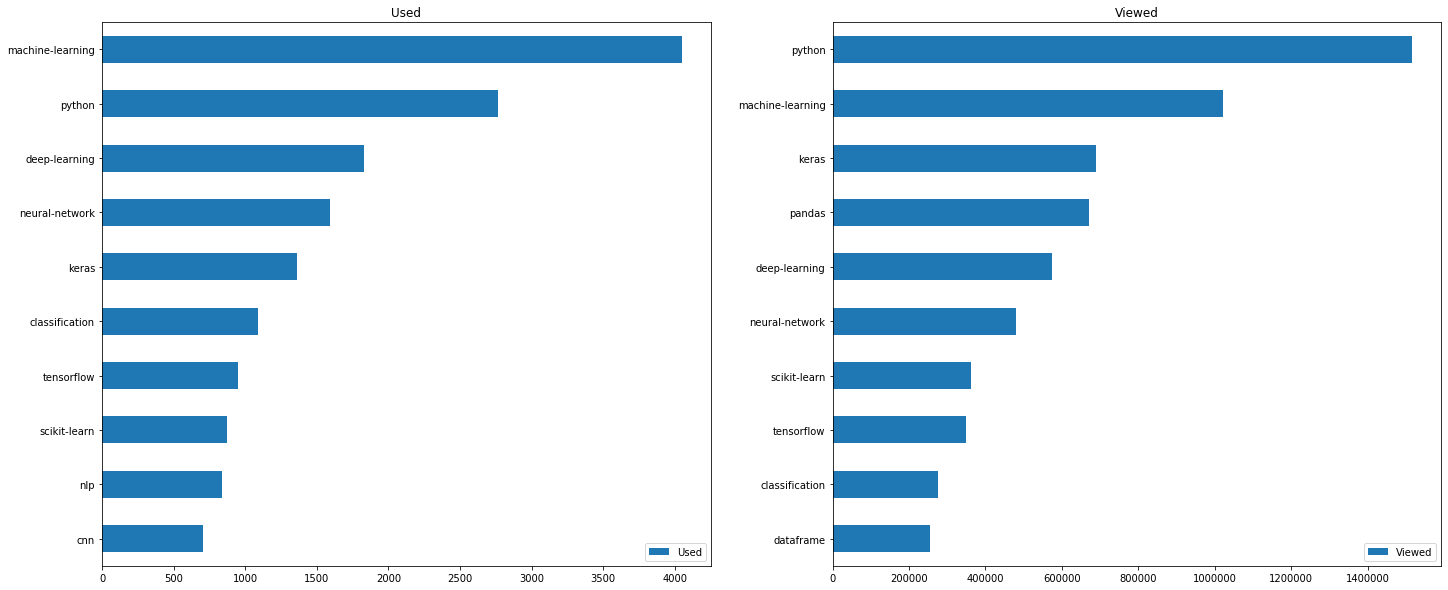

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.sort_values('Used').plot(kind='barh', ax=axes[0], subplots=True)
most_viewed.sort_values('Viewed').plot(kind='barh', ax=axes[1], subplots=True)

We notice that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: *python*, *machine-learning*, *deep-learning*, *neural-network*, *keras*, *tensorflow*, *classification*, *scikit-learn*.
Most of the top tags are all intimately related with one central machine learning theme: Deep Learning.

## Is Deep Learning just a fad?

To answer this question, we'll find out:
 - How many deep learning questions are asked per time period
 - The total amount of questions per time period
 - How many deep learning questions there are relative to the total amount of questions per time period
 
First, we need to go back to the DSSE and extract all the questions ever asked, with their dates and tags:

    SELECT Id, CreationDate, Tags
      FROM posts
     WHERE PostTypeId = 1;
     
The data is saved as *'all_questions.csv'*.

In [9]:
# Repeat the initial steps
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_questions['Tags'] = all_questions['Tags'].str.strip('<>').str.split('><')
all_questions.head()

,Id,CreationDate,Tags
0,14352,2016-10-04 13:13:15,"[neural-network, deep-learning]"
1,14355,2016-10-04 13:54:26,"[python, scikit-learn, k-means]"
2,14356,2016-10-04 14:32:19,"[classification, correlation, binary]"
3,14368,2016-10-05 03:52:38,"[performance, library, gpu]"
4,14369,2016-10-05 04:46:00,"[machine-learning, classification, statistics,..."


In [10]:
# Define which tags are related to Deep Learning
dl_tags = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]

# Create a categorization column
def dl_related(list):
    for tag in list:
        if tag in dl_tags:
            return 1
    return 0

all_questions['DeepLearning'] = all_questions['Tags'].apply(dl_related)
all_questions.sample(5)

,Id,CreationDate,Tags,DeepLearning
15903,20186,2017-07-05 12:06:00,"[bigdata, nosql, json]",0
19977,22863,2017-09-06 04:18:58,[anomaly-detection],0
7270,55928,2019-07-18 14:42:28,"[python, scikit-learn, categorical-data, encod...",1
10576,46705,2019-03-05 13:58:54,"[machine-learning, python, feature-extraction]",0
19723,50967,2019-04-26 08:46:11,"[cross-validation, overfitting]",0


We'll aggregate the numbers by quarter, starting at Q3 of 2014 and ending at Q3 of 2020.

In [11]:
# Remove out-of-scope data
import datetime as dt
all_questions = all_questions[(all_questions['CreationDate'] >= dt.datetime.strptime('2014-07-01', '%Y-%m-%d')) & (all_questions['CreationDate'] < dt.datetime.strptime('2020-10-01', '%Y-%m-%d'))]

In [12]:
# Create quarter numbers
all_questions['Quarter'] = all_questions['CreationDate'].dt.year.astype(str) + 'Q' + all_questions['CreationDate'].dt.quarter.astype(str)
all_questions.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,14352,2016-10-04 13:13:15,"[neural-network, deep-learning]",1,2016Q4
1,14355,2016-10-04 13:54:26,"[python, scikit-learn, k-means]",1,2016Q4
2,14356,2016-10-04 14:32:19,"[classification, correlation, binary]",0,2016Q4
3,14368,2016-10-05 03:52:38,"[performance, library, gpu]",0,2016Q4
4,14369,2016-10-05 04:46:00,"[machine-learning, classification, statistics,...",0,2016Q4


In [24]:
# Calculate DeepLearning-related question rates
quarter_stats = all_questions.groupby('Quarter').agg({'Id': 'size', 'DeepLearning': 'sum'})
quarter_stats.columns = ['Total_Questions', 'DL_Questions']
quarter_stats['DL_Rate'] = quarter_stats['DL_Questions'] / quarter_stats['Total_Questions']
quarter_stats.reset_index(inplace=True)
quarter_stats.head()

,Quarter,Total_Questions,DL_Questions,DL_Rate
0,2014Q3,188,13,0.069149
1,2014Q4,214,21,0.098131
2,2015Q1,190,18,0.094737
3,2015Q2,284,28,0.098592
4,2015Q3,311,45,0.144695


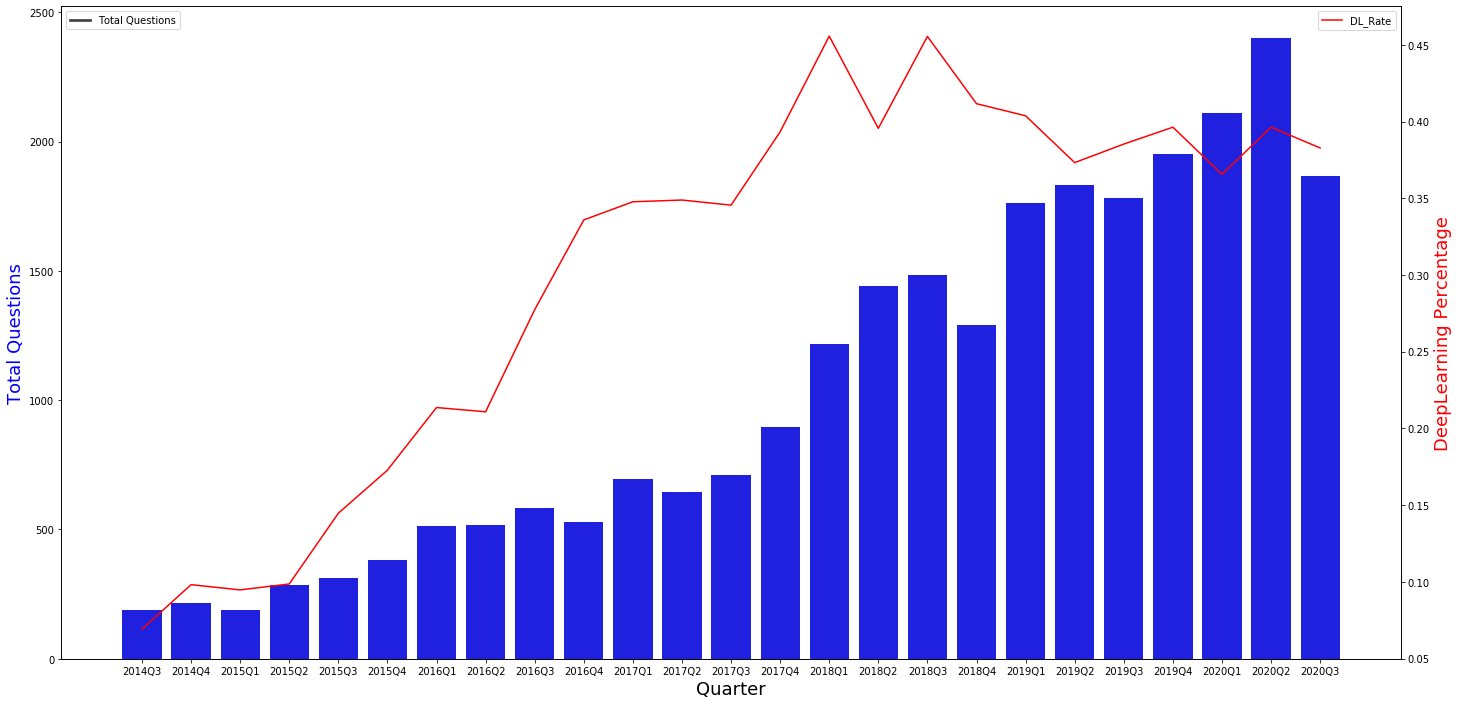

In [58]:
# Visualize the result
fig, ax1 = plt.subplots(figsize=(24, 12))
sns.barplot(x='Quarter', y='Total_Questions', data=quarter_stats, color='blue')
ax1.set_ylabel('Total Questions', fontsize=18, color='blue')
plt.legend(labels=['Total Questions'], loc='upper left')
ax1.set_xlabel('Quarter', fontsize=18)

ax2 = ax1.twinx()
sns.lineplot(x='Quarter', y='DL_Rate', data=quarter_stats, color='red')
ax2.set_ylabel('DeepLearning Percentage', fontsize=18, color='red')
plt.legend(labels=['DL_Rate'])

It seems that Deep Learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing.